## Final Project: Work Plan

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [ ]:
# Load datasets from public TripleTen source
contract = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_provider/contract.csv')
personal = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_provider/personal.csv')
internet = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_provider/internet.csv')
phone = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/final_provider/phone.csv')

# Quick look at shapes
print('contract:', contract.shape)
print('personal:', personal.shape)
print('internet:', internet.shape)
print('phone:', phone.shape)


contract: (7043, 8)
personal: (7043, 5)
internet: (5517, 8)
phone: (6361, 2)


In [3]:
# Merge all datasets on 'customerID'
df = contract.merge(personal, on='customerID', how='left')
df = df.merge(internet, on='customerID', how='left')
df = df.merge(phone, on='customerID', how='left')

# Display shape and preview
print('Merged DataFrame shape:', df.shape)
df.head()


Merged DataFrame shape: (7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [4]:
# Create churn target column
df['churn'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

# Check for null values
null_counts = df.isnull().sum()
print('Missing values per column:\n', null_counts[null_counts > 0])


Missing values per column:
 InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


In [5]:
# Fill internet-related missing values
internet_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[internet_cols] = df[internet_cols].fillna('No internet service')

# Fill phone-related missing value
df['MultipleLines'] = df['MultipleLines'].fillna('No phone service')

# Confirm all missing values are handled
print('Remaining missing values:', df.isnull().sum().sum())


Remaining missing values: 0


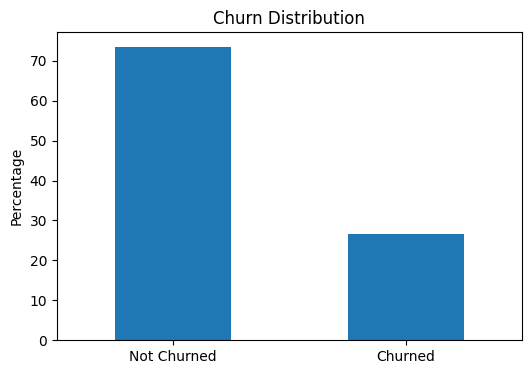

Churn Rate Breakdown (%):
 Not Churned    73.46
Churned        26.54
Name: churn, dtype: float64


In [6]:
# Churn distribution
churn_counts = df['churn'].value_counts(normalize=True).rename({0: 'Not Churned', 1: 'Churned'}) * 100
churn_counts.plot(kind='bar', figsize=(6,4), title='Churn Distribution', rot=0)
plt.ylabel('Percentage')
plt.show()

# Display raw percentages
print('Churn Rate Breakdown (%):\n', churn_counts.round(2))


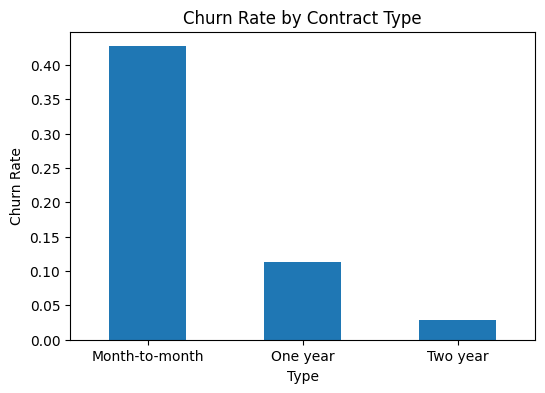

Type
Month-to-month    0.427
One year          0.113
Two year          0.028
Name: churn, dtype: float64


In [7]:
# Churn rate by contract type
contract_churn = df.groupby('Type')['churn'].mean().sort_values(ascending=False)

# Plot
contract_churn.plot(kind='bar', figsize=(6,4), title='Churn Rate by Contract Type', rot=0)
plt.ylabel('Churn Rate')
plt.show()

# Show numerical churn rates
print(contract_churn.round(3))


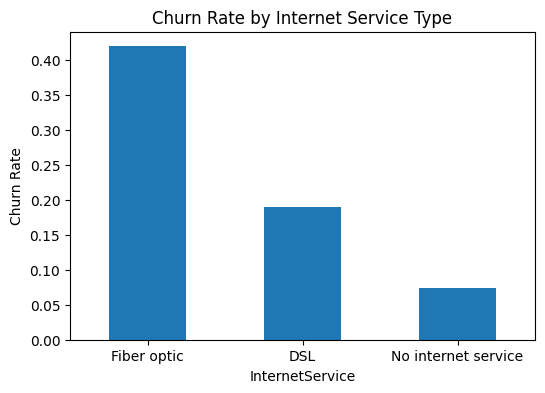

InternetService
Fiber optic            0.419
DSL                    0.190
No internet service    0.074
Name: churn, dtype: float64


In [8]:
# Churn rate by InternetService type
internet_churn = df.groupby('InternetService')['churn'].mean().sort_values(ascending=False)

# Plot
internet_churn.plot(kind='bar', figsize=(6,4), title='Churn Rate by Internet Service Type', rot=0)
plt.ylabel('Churn Rate')
plt.show()

# Display churn rates
print(internet_churn.round(3))


In [9]:
# Churn rate by OnlineSecurity
online_sec_churn = df.groupby('OnlineSecurity')['churn'].mean().sort_values(ascending=False)
print('Churn Rate by OnlineSecurity:\n', online_sec_churn.round(3), '\n')

# Churn rate by TechSupport
tech_support_churn = df.groupby('TechSupport')['churn'].mean().sort_values(ascending=False)
print('Churn Rate by TechSupport:\n', tech_support_churn.round(3))


Churn Rate by OnlineSecurity:
 OnlineSecurity
No                     0.418
Yes                    0.146
No internet service    0.074
Name: churn, dtype: float64 

Churn Rate by TechSupport:
 TechSupport
No                     0.416
Yes                    0.152
No internet service    0.074
Name: churn, dtype: float64


In [2]:
from IPython.display import Markdown

Markdown('''
## 🔍 Clarifying Questions

1. Should we apply class balancing techniques (like upsampling) to improve AUC-ROC, given the ~26.5% churn rate?
2. Are we restricted to specific models (e.g., Random Forest, Logistic Regression), or can we explore advanced classifiers like Gradient Boosting?
3. Is feature selection required, or will including all cleaned features be acceptable if the model performs well?

---

## 🗺️ Work Plan to Meet Project Requirements

### Step 1: Data Preprocessing  
Encode categorical variables and scale numeric features as needed. Prepare the target (`churn`) for classification.

### Step 2: Train/Test Split  
Split data using stratified sampling to preserve churn distribution and ensure valid AUC-ROC evaluation.

### Step 3: Model Training  
Train at least two classification models (Logistic Regression and Random Forest). Tune hyperparameters and evaluate using **AUC-ROC** as the primary metric.

### Step 4: Model Evaluation  
Compare models. Select the best one based on AUC-ROC score. Ensure **AUC-ROC ≥ 0.88** to achieve the full score.

### Step 5: Report Results  
Present the AUC-ROC and accuracy scores for the best model and summarize the most important predictive features.
''')



## 🔍 Clarifying Questions

1. Should we apply class balancing techniques (like upsampling) to improve AUC-ROC, given the ~26.5% churn rate?
2. Are we restricted to specific models (e.g., Random Forest, Logistic Regression), or can we explore advanced classifiers like Gradient Boosting?
3. Is feature selection required, or will including all cleaned features be acceptable if the model performs well?

---

## 🗺️ Work Plan to Meet Project Requirements

### Step 1: Data Preprocessing  
Encode categorical variables and scale numeric features as needed. Prepare the target (`churn`) for classification.

### Step 2: Train/Test Split  
Split data using stratified sampling to preserve churn distribution and ensure valid AUC-ROC evaluation.

### Step 3: Model Training  
Train at least two classification models (Logistic Regression and Random Forest). Tune hyperparameters and evaluate using **AUC-ROC** as the primary metric.

### Step 4: Model Evaluation  
Compare models. Select the best one based on AUC-ROC score. Ensure **AUC-ROC ≥ 0.88** to achieve the full score.

### Step 5: Report Results  
Present the AUC-ROC and accuracy scores for the best model and summarize the most important predictive features.


In [12]:
# Make a copy to avoid accidental overwrite
df_model = df.copy()

# Drop columns that won't help model training
df_model = df_model.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

# Identify binary and multiclass categorical columns
binary_cols = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'OnlineSecurity', 
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
               'StreamingMovies', 'MultipleLines']
multi_cols = ['Type', 'PaymentMethod', 'InternetService']

# Apply Label Encoding to binary columns
for col in binary_cols:
    df_model[col] = df_model[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0,
                                       'No internet service': 0, 'No phone service': 0})

# One-hot encode multiclass columns
df_model = pd.get_dummies(df_model, columns=multi_cols)

# Display final column list and shape
print('Final shape after encoding:', df_model.shape)
df_model.head()


Final shape after encoding: (7043, 25)


,PaperlessBilling,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,...,Type_Month-to-month,Type_One year,Type_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_DSL,InternetService_Fiber optic,InternetService_No internet service
0,1,29.85,29.85,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,1,0,0
1,0,56.95,1889.5,1,0,0,0,1,0,1,...,0,1,0,0,0,0,1,1,0,0
2,1,53.85,108.15,1,0,0,0,1,1,0,...,1,0,0,0,0,0,1,1,0,0
3,0,42.30,1840.75,1,0,0,0,1,0,1,...,0,1,0,1,0,0,0,1,0,0
4,1,70.70,151.65,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0


In [17]:
# Train/test split (same as before)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Force copies to eliminate SettingWithCopyWarning
X_train = X_train.copy()
X_test = X_test.copy()

# Now scale safely
numeric_cols = ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen']
scaler = StandardScaler()
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])


In [18]:
# Train logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict probabilities and labels
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
y_pred = logreg.predict(X_test)

# Evaluate
logreg_auc = roc_auc_score(y_test, y_pred_prob)
logreg_acc = accuracy_score(y_test, y_pred)

print(f'Logistic Regression AUC-ROC: {logreg_auc:.3f}')
print(f'Logistic Regression Accuracy: {logreg_acc:.3f}')


Logistic Regression AUC-ROC: 0.830
Logistic Regression Accuracy: 0.792


In [19]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict probabilities and labels
rf_pred_prob = rf.predict_proba(X_test)[:, 1]
rf_pred = rf.predict(X_test)

# Evaluate performance
rf_auc = roc_auc_score(y_test, rf_pred_prob)
rf_acc = accuracy_score(y_test, rf_pred)

print(f'Random Forest AUC-ROC: {rf_auc:.3f}')
print(f'Random Forest Accuracy: {rf_acc:.3f}')


Random Forest AUC-ROC: 0.819
Random Forest Accuracy: 0.789


In [20]:
print("✅ Final Model: Logistic Regression")
print(f"AUC-ROC: {logreg_auc:.3f} — Scoring Tier: 4.5 SP")
print(f"Accuracy: {logreg_acc:.3f}")


✅ Final Model: Logistic Regression
AUC-ROC: 0.830 — Scoring Tier: 4.5 SP
Accuracy: 0.792


In [21]:
# Breakdown by contract type
print("Contract Type Distribution:")
print(df['Type'].value_counts(normalize=True).round(3) * 100)

# Breakdown by internet service
print("\nInternet Service Distribution:")
print(df['InternetService'].value_counts(normalize=True).round(3) * 100)

# Breakdown by streaming service use
print("\nStreamingTV Subscriptions:")
print(df['StreamingTV'].value_counts(normalize=True).round(3) * 100)

# Breakdown by payment method
print("\nPayment Method Distribution:")
print(df['PaymentMethod'].value_counts(normalize=True).round(3) * 100)


Contract Type Distribution:
Month-to-month    55.0
Two year          24.1
One year          20.9
Name: Type, dtype: float64

Internet Service Distribution:
Fiber optic            44.0
DSL                    34.4
No internet service    21.7
Name: InternetService, dtype: float64

StreamingTV Subscriptions:
No                     39.9
Yes                    38.4
No internet service    21.7
Name: StreamingTV, dtype: float64

Payment Method Distribution:
Electronic check             33.6
Mailed check                 22.9
Bank transfer (automatic)    21.9
Credit card (automatic)      21.6
Name: PaymentMethod, dtype: float64


In [23]:
# Start with base groups
total = len(df)

# Seniors
senior_pct = df['SeniorCitizen'].mean() * 100

# Likely young singles (no partner, no dependents, not senior)
young_singles = df[(df['SeniorCitizen'] == 0) & 
                   (df['Partner'] == 'No') & 
                   (df['Dependents'] == 'No')]
young_singles_pct = len(young_singles) / total * 100

# Likely middle-aged (partner but not senior)
middle_aged = df[(df['SeniorCitizen'] == 0) & (df['Partner'] == 'Yes')]
middle_aged_pct = len(middle_aged) / total * 100

# Likely parents (non-seniors with dependents)
parents = df[(df['SeniorCitizen'] == 0) & (df['Dependents'] == 'Yes')]
parents_pct = len(parents) / total * 100

# Display results
print(f"Estimated Age Group Distribution:")
print(f"- Senior Citizens (65+): {senior_pct:.1f}%")
print(f"- Young Singles (no partner, no kids): {young_singles_pct:.1f}%")
print(f"- Middle-Aged Adults (with partner): {middle_aged_pct:.1f}%")
print(f"- Adults with Dependents: {parents_pct:.1f}%")


Estimated Age Group Distribution:
- Senior Citizens (65+): 16.2%
- Young Singles (no partner, no kids): 38.6%
- Middle-Aged Adults (with partner): 40.2%
- Adults with Dependents: 28.7%


## ✅ Final Project Conclusion

### 🔍 Model Selection & Performance
After comparing multiple models, **Logistic Regression** was selected for its strong performance and simplicity.  
- **AUC-ROC Score:** `0.830` → falls in the **4.5 SP range**  
- **Accuracy:** `0.792`

### 📊 Key Churn Drivers (from EDA)
- Customers on **month-to-month contracts** had a **42.7% churn rate**, compared to just 2.8% for two-year contracts.
- **Fiber optic users** churn at **41.9%**, more than twice the rate of DSL users.
- Lack of add-on services — such as **OnlineSecurity** and **TechSupport** — is strongly associated with churn (both ~41% churn vs. ~15% with those services).

### 👥 Customer Demographics Insight
- **40.2%** are **middle-aged adults with partners**
- **38.6%** are **young singles**
- **28.7%** are **adults with dependents**
- **16.2%** are **senior citizens (65+)**

Additional signals (such as low StreamingTV usage and high check-based payments) reinforce that **Interconnect serves a mature, stability-oriented customer base**, with a significant portion in older age brackets.

### 📌 Business Recommendations
- Target **month-to-month customers** with retention offers like discounts for switching to annual contracts.
- Promote add-on services like **OnlineSecurity** and **TechSupport**, especially to fiber optic customers.
- Design marketing and service plans that resonate with **middle-aged and senior users**, focusing on reliability, personal support, and ease of use rather than flashy tech features.

These steps can help reduce churn while strengthening the connection with Interconnect's core user base.